## Load the Record

In [1]:
import pyNUISANCE as pn
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata",
    "recordref":"hepdata-sandbox:1731941452"})

Welcome to JupyROOT 6.30/04


In [2]:
hepdata_rec.get_analyses()

['diffxsec_q2', 'diffxsec_electron_theta_energy']

In [3]:
ana = hepdata_rec.analysis("diffxsec_q2")

## Generate Some Events

probe pdg: 14
probe histogram yml: /root/software/NUISANCEMC/eventinput/data/hepdata-sandbox/1731936240/HEPData-1731936240-v1/flux_numode_numu.yaml
Target: 1000060120[22.333333333333332], 1000170350[5.333333333333333], 1000010010[3.6666666666666665], 1000220480, 1000080160


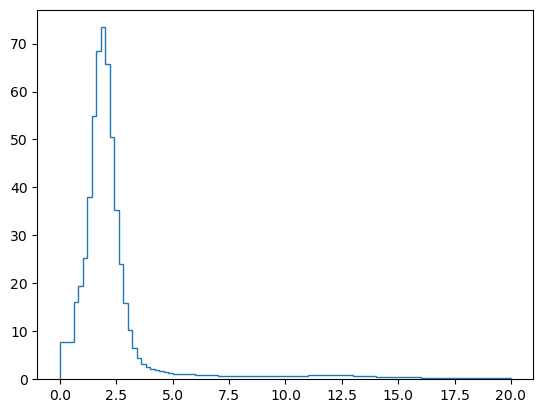

In [10]:
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_nova_nueccinc.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_nova_nueccinc.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(f"probe pdg: {probe_flux_count.probe_pdg}")
print(f"probe histogram yml: {probe_flux_count.source}")

print("Target:",", ".join([ str(tgt) for tgt in ana.get_target() ]))

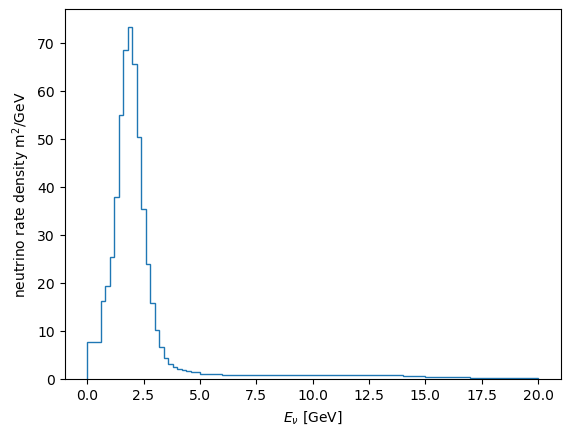

In [13]:
import matplotlib.pyplot as plt

probe_flux_count_density.spectrum.mpl().hist(histtype="step")
plt.xlabel(r"$E_{\nu}$ [GeV]")
plt.ylabel(r"neutrino rate density m$^{2}$/GeV")
plt.show()

In [5]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_nova_nueccinc.hepmc3.gz ]; then
    neut-quickstart -t C -s nue \
                -f flux_for_nova_nueccinc.root,flux_count \
                -n 100000 \
                -o events_for_nova_nueccinc.hepmc3.gz
fi

## Build the Comparison

In [6]:
neut_events = pn.EventSource("events_for_nova_nueccinc.hepmc3.gz")
if not neut_events:
    print("Failed to read NEUT file")

In [7]:
neut_comparison = ana.process(neut_events)
print(f"neut likelihood = {neut_comparison.likelihood()}")

neut likelihood = 43.65745555910611


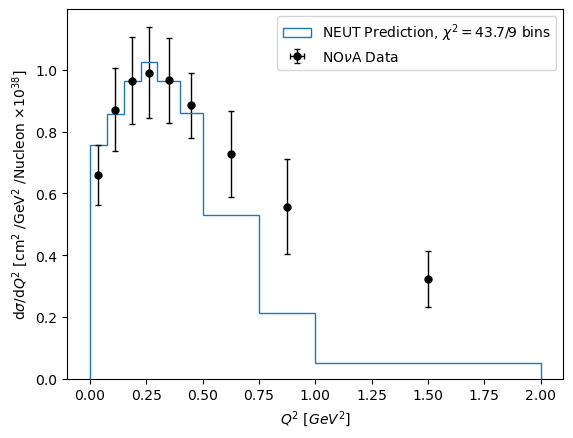

In [8]:
nbins = len(neut_comparison.predictions[0].binning.bins)

neut_comparison.data[0].mpl().data_hist(label=r"NO$\nu$A Data")
neut_comparison.predictions[0].mpl().hist(label=r"NEUT Prediction, $\chi^{2} = " \
                                     + f"{neut_comparison.likelihood():.3}" \
                                     + f"/{nbins}$ bins", histtype="step")

plt.legend()
plt.show()